In [1]:
import cv2
import time
import pickle
import skimage.io
import numpy as np
import tkinter as tk
from functions import *
from tkinter import *
import scipy.stats as st
from matplotlib import pyplot as plt
from tkinter import filedialog as fd
from tkinter import messagebox as mb

class Retina:
    def __init__(self):
        self.backProjectedVector = None
        self.normalizationVector = None
        self.optimumNumThreads = None
        self.sampledVector = None
        self.coeff_layers = None
        self.index_layers = None
        self.fixation = None
        self.cropped = None
        self.coeffs = None
        self.locs = None
        self.cap = None
        self.res = None
        self.h = None
        self.w = None
        
    def initCapture(self):
        self.cap = cv2.VideoCapture(0)
        if self.res is not None:
            self.cap.set(3, self.res[1])
            self.cap.set(4, self.res[0])
        
    def releaseCapture(self):
        self.cap.release()
        
    def setInputResolution(self, w=100000, h=100000, verbose=False):
        self.initCapture()
        self.cap.set(3, w)
        self.cap.set(4, h)
        w = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.res = np.array([h,w])
        self.releaseCapture()
        if verbose:
            print("Camera resolution set to %ix%i"%(w, h))

    def setFixation(self, x, y):
        if self.res[0] > self.h and self.res[1] > self.w:
            self.fixation = np.array([y,x])
            x1, y1, x2, y2 = int(x-(self.w//2)), int(y-(self.h//2)), int(x+(self.w//2)), int(y+(self.h//2))
            self.cropped = (y1, y2, x1, x2)
        elif self.res[0] < self.h and self.res[1] < self.w:
            raise Exception("Unspported case: Retina is larger than input image")
        else:
            raise Exception(""" Unspported case: Ambiguous cropping parameters
            Retina size is: %ix%i
            Input size is: %ix%i
            Either one can be cropped. Please make sure one of them is larger in both dimensions.
            """%(self.w, self.h, self.res[1], self.res[0]))
        
    def loadLocations(self):
        root = Tk()
        root.attributes("-topmost", True)
        root.withdraw()
        i = 0
        while self.locs is None:
            i+= 1
            try:
                fname = fd.askopenfilename(title = "Select locations data", filetypes = (("Pickle Object","*.pkl"),("all files","*.*")))
                self.locs = pickle.load(open(fname, "rb" ), encoding='latin1')
                if self.locs.shape[-1] != 7:
                    mb.showerror("Failed!", "Data has wrong dimensions.\nPlease make sure you have selected the correct file", parent=root)
                    self.locs = None
            except:
                self.locs = None
                mb.showerror("Failed!", "Something went wrong while trying to load location data.\nPlease make sure you have selected the correct file and that the file is not in use by other processes.", parent=root)
            if self.locs is None and i>=3:
                if mb.askyesno("Data not loaded correctly!", "Would you like to abort?", parent=root):
                    break
        if self.locs is None:
            quit()
        root.destroy()
        self.sampledVector = np.zeros(len(self.locs)+1).astype('uint64')
        self.w = 2*int(np.max(np.abs(self.locs[:,0])) + np.max(self.locs[:,6]//2)+1)
        self.h = 2*int(np.max(np.abs(self.locs[:,1])) + np.max(self.locs[:,6]//2)+1)

    def loadCoefficients(self):
        root = Tk()
        root.attributes("-topmost", True)
        root.withdraw()
        i = 0
        while self.coeffs is None:
            i+= 1
            try:
                fname = fd.askopenfilename(title = "Select coefficients data", filetypes = (("Pickle Object","*.pkl"),("all files","*.*")))
                self.coeffs = np.squeeze(pickle.load(open(fname, "rb" ), encoding='latin1'))
                if len(self.coeffs.shape) != 1:
                    mb.showerror("Failed!", "Data has wrong dimensions.\nPlease make sure you have selected the correct file", parent=root)
                    self.coeffs = None
            except:
                self.coeffs = None
                mb.showerror("Failed!", "Something went wrong while trying to load coefficients data.\nPlease make sure you have selected the correct file and that the file is not in use by other processes.", parent=root)
            if self.coeffs is None and i>=3:
                if mb.askyesno("Data not loaded correctly!", "Would you like to abort?", parent=root):
                    break
        if self.coeffs is None:
            quit()
            
    def generateLayers(self):
        self.locs[:,:2] = (self.locs[:,:2]+ np.array((self.w//2,self.h//2)))
        overlapCounter = np.zeros((self.h,self.w),dtype='uint8')
        for idx in range(len(self.locs)):
            size = int(self.locs[idx][6])
            offset = size/2.0
            x, y = np.round(self.locs[idx][:2])
            x1, y1, x2, y2 = int(x-offset), int(y-offset), int(x+offset), int(y+offset)
            overlapCounter[y1:y2,x1:x2] += 1
        nLayers = np.max(overlapCounter)
        self.coeff_layers = []
        [self.coeff_layers.append(np.zeros((self.h,self.w))) for i in range(nLayers)]
        self.index_layers = []
        [self.index_layers.append(np.zeros((self.h,self.w))) for i in range(nLayers)]
        for idx in range(len(self.locs)):
            values = self.coeffs[idx]
            size = int(self.locs[idx][6])
            offset = size/2.0
            x, y = np.round(self.locs[idx][:2])
            pixelCoords = [(int(x+i-offset), int(y+j-offset), values[j,i]) for j in range(size) for i in range(size)]
            for coord in pixelCoords:
                x, y, c = coord
                for i in range(nLayers):
                    if self.coeff_layers[i][y,x] == 0:
                        self.coeff_layers[i][y,x] = c
                        self.index_layers[i][y,x] = idx+1
                        break
        scaling_factor = 255 / np.max(self.coeff_layers)
        for i in range(len(self.coeff_layers)):
            self.coeff_layers[i] = (self.coeff_layers[i]*scaling_factor).astype('uint8').reshape(self.h*self.w)
            self.index_layers[i] = self.index_layers[i].astype('uint32').reshape(self.h*self.w)
        self.setFixation(self.res[1]//2,self.res[0]//2)
        
    def sample(self, img):
        zeros_int32(self.sampledVector)
        if self.cropped is not None:
            y1, y2, x1, x2 = self.cropped
            img = img[y1:y2, x1:x2]
        img = img.reshape(self.h*self.w)
        for i in range(len(self.coeff_layers)):
            sample(img, self.coeff_layers[i], self.index_layers[i], self.sampledVector)

    def createNormalizationImage(self):
        self.backProjectedVector = np.zeros(self.h*self.w).astype('uint64')
        ones = np.ones((self.res[0],self.res[1])).astype('uint8')
        self.sample(ones)
        for i in range(len(self.coeff_layers)):
            backProject(self.sampledVector,  self.coeff_layers[i],  self.index_layers[i],  self.backProjectedVector)
        self.normalizationVector = np.copy(self.backProjectedVector)
        self.normalizationVector[np.where(self.normalizationVector==0)]=1

    def backProject(self):
        zeros_int32(self.backProjectedVector)
        for i in range(len(self.coeff_layers)):
            backProject(self.sampledVector,  self.coeff_layers[i],  self.index_layers[i],  self.backProjectedVector)
        normalize(self.backProjectedVector, self.normalizationVector)

img = skimage.io.imread('dock.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [2]:
def removePeaks(a, p=99):
    return list(filter(lambda x: x<np.percentile(a,p), a))

def format_result(times):
    suffix = ['nS', 'µS','mS','S']
    mean=np.mean(times)
    std=np.std(times)
    s1=int(np.log(mean) / np.log(1000))
    s2=int(np.log(std) / np.log(1000))
    if s1>3:
        s1=3
    if s2>3:
        s2=3
    mean /= 1000**s1
    std /= 1000**s2
    return ('%.2f%s ± %.1f%s per loop (%i runs)'%(mean, suffix[s1], std, suffix[s2], len(times)))

def bench(fn,nLoops,timeout=10,fmt=True):
    times = []
    initial = time.time()
    while len(times)<nLoops and time.time()-initial < timeout:
        start = time.time_ns()
        fn()
        end = time.time_ns()
        times.append(end-start)
    if fmt:
        return format_result(times)
    else:
        return (np.mean(times),np.std(times),len(times))

Camera resolution set to 1920x1080
Generating layers took 29.94 seconds


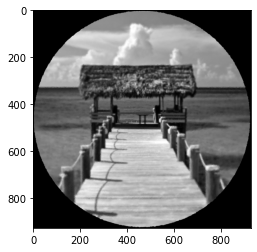

In [3]:
R = Retina()
R.setInputResolution(verbose=True)
R.loadLocations()
R.loadCoefficients()
start = time.time()
R.generateLayers()
end = time.time()
print("Generating layers took %.2f seconds" %(end - start))
R.createNormalizationImage()
R.sample(img_gray)
R.backProject()
plt.figure()
plt.imshow(R.backProjectedVector.reshape((R.h,R.w)), cmap='gray')
plt.imsave('backProjected.png', R.backProjectedVector.reshape((R.h,R.w)), cmap='gray')
plt.show()

In [8]:
print(bench(lambda:R.sample(img_gray), 1000))

31.77mS ± 1.2mS per loop (315 runs)


In [5]:
#liveCapture = None
frame_times = []

if 'liveCapture'  in globals():
    R.initCapture()
    prev_frame_time = 0
    new_frame_time = 0
    try:
        while(R.cap.isOpened()):
            # Capture a frame
            ret, frame = R.cap.read()
            if not ret: 
                break
            # Our operations on the frame go here
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            R.sample(gray)
            R.backProject()
            new_frame_time = time.time()
            frame_times.append((new_frame_time-prev_frame_time)*1000)
            prev_frame_time = new_frame_time 
            # Display the resulting frame
            cv2.imshow('Capture',gray)
            cv2.imshow('Back Projected',R.backProjectedVector.reshape((R.h,R.w)).astype('uint8'))
            key = cv2.waitKey(1)
            if key == 27: #esc
                    break
    finally:
        # When everything done, release the capture
        R.releaseCapture()
        cv2.destroyAllWindows()
        times = removePeaks(frame_times[2:])
        plt.figure(figsize=(16,9))
        plt.title('Frametime analysis')
        plt.xlabel('Time (s)')
        plt.ylabel('Frametime (ms)')
        plt.plot(np.cumsum(times)/1000,times)
        plt.plot(np.cumsum(times)/1000,times,'r.')
        plt.show()
        print("FPS analysis:")
        print("Average FPS:\t%.2f"%(1000/np.mean(frame_times[2:])))
        print("1%% lows:\t%.2f"%(1000/np.percentile(frame_times[2:],99)))
        print("0.1%% lows:\t%.2f"%(1000/np.percentile(frame_times[2:],99.9)))

In [6]:
import threading

"""
Demo of real time variable fixation
WARNING : BUGGY VERSION, THREADS FAILS TO CLOSE, REQUIRES MANUAL INTERRUPTION OF KERNEL
Searching for a fix as the thread does return but does not join which is really odd;
Potential issue with tkinter
"""

#buggyLiveCapture = None
frame_times = []

def liveDemo():
    R.initCapture()
    prev_frame_time = 0
    new_frame_time = 0
    try:
        while(R.cap.isOpened()):
            # Capture a frame
            ret, frame = R.cap.read()
            if not ret: 
                break
            # Our operations on the frame go here
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            R.setFixation(slider1.get(),slider2.get())
            R.sample(gray)
            R.backProject()
            new_frame_time = time.time()
            frame_times.append((new_frame_time-prev_frame_time)*1000)
            prev_frame_time = new_frame_time 
            # Display the resulting frame
            cv2.imshow('Capture',gray)
            cv2.imshow('Back Projected',R.backProjectedVector.reshape((R.h,R.w)).astype('uint8'))
            key = cv2.waitKey(1)
            if key == 27: #esc
                break
    finally:
        # When everything done, release the capture
        R.releaseCapture()
        cv2.destroyAllWindows()
        times = removePeaks(frame_times[2:])
        plt.figure(figsize=(16,9))
        plt.title('Frametime analysis')
        plt.xlabel('Time (s)')
        plt.ylabel('Frametime (ms)')
        plt.plot(np.cumsum(times)/1000,times)
        plt.plot(np.cumsum(times)/1000,times,'r.')
        plt.show()
        print("FPS analysis:")
        print("Average FPS:\t%.2f"%(1000/np.mean(frame_times[2:])))
        print("1%% lows:\t%.2f"%(1000/np.percentile(frame_times[2:],99)))
        print("0.1%% lows:\t%.2f"%(1000/np.percentile(frame_times[2:],99.9)))
        root.destroy()
    
    return 0


if 'buggyLiveCapture'  in globals():
    t = threading.Thread(target=liveDemo)
    xlims = (R.w//2,R.res[1]-(R.w//2))
    ylims = (R.h//2,R.res[0]-(R.h//2))
    root = Tk()
    root.title("Fixation picker")
    root.attributes("-topmost", True)
    root.attributes("-topmost", False)
    slider1 = Scale(root, from_=xlims[0], to=xlims[1], tickinterval=(R.res[1]-R.w)//9, length=600, sliderlength=20, orient=HORIZONTAL)
    slider1.set(sum(xlims)//2)
    slider1.grid(row=0,column=0,padx=(60,0))
    slider2 = Scale(root, from_=ylims[0], to=ylims[1], tickinterval=(R.res[0]-R.h)//9, length=400, sliderlength=20)
    slider2.set(sum(ylims)//2)
    slider2.grid(row=1,column=0,sticky=W)
    Button(root, text='CENTER', command=lambda:(slider1.set(sum(xlims)//2),slider2.set(sum(ylims)//2))).grid(row=2,column=0)
    t.start()
    root.mainloop()
    t.join()